# Requirements

In [1]:
%%capture
!git lfs install
!pip install datasets
!pip install accelerate
!pip install bitsandbytes
!pip install trl

In [2]:
from datasets import load_dataset

dataset = load_dataset("turkish_product_reviews")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
dataset.keys()

dict_keys(['train'])

In [4]:
print(dataset["train"].features)

print(dataset["train"][0])

{'sentence': Value(dtype='string', id=None), 'sentiment': ClassLabel(names=['negative', 'positive'], id=None)}
{'sentence': 'fena değil paraya göre iyi.', 'sentiment': 1}


In [5]:
df = dataset["train"].to_pandas()

# Imports

In [6]:
import pandas as pd
import torch
from IPython.display import clear_output

# EDA

## Checking data quality

In [7]:
df

,sentence,sentiment
0,fena değil paraya göre iyi.,1
1,ürün kaliteli ve çok kullanışlı kargo ya veril...,1
2,fiyat-performans karşılaştırması yaptığınızda ...,1
3,bu fiyata çok iyi,1
4,fiyat ve performans olarak gayet iyi,1
...,...,...
235160,odada bu buhar makinası çalışırken uyumak kesi...,0
235161,ürün gayet güzel ve sağlam.tek kusuru sesli ça...,0
235162,hepsiburadaya tesekkurler,0
235163,çok ufak ve basit plastikten yapılmış. hiç kul...,0


In [8]:
def check_data(data):
  null_data = data.isna().sum()
  null_percentage = data.isna().sum() / len(data)
  null_percentage = null_percentage.apply(lambda x: f"{x:.1%}")
  print("Duplicated data: ", data.duplicated().sum())
  result = pd.concat([null_data, null_percentage], axis=1)
  result.columns = ["Null Data", "Null Percentage"]
  return result
check_data(df)

Duplicated data:  1580


,Null Data,Null Percentage
sentence,0,0.0%
sentiment,0,0.0%


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df

,sentence,sentiment
0,fena değil paraya göre iyi.,1
1,ürün kaliteli ve çok kullanışlı kargo ya veril...,1
2,fiyat-performans karşılaştırması yaptığınızda ...,1
3,bu fiyata çok iyi,1
4,fiyat ve performans olarak gayet iyi,1
...,...,...
235160,odada bu buhar makinası çalışırken uyumak kesi...,0
235161,ürün gayet güzel ve sağlam.tek kusuru sesli ça...,0
235162,hepsiburadaya tesekkurler,0
235163,çok ufak ve basit plastikten yapılmış. hiç kul...,0


In [11]:
import pandas as pd
import string

def has_uppercase(data):
    return any(char.isupper() for char in data)

def has_punctuation(data):
    if isinstance(data, str):
        return any(char in string.punctuation for char in data)
    else:
        return False

def has_digit(data):
    return any(char.isdigit() for char in data)

def has_special_char(data):
    special_chars = []
    for char in data:
        if not char.isalnum():
            special_chars.append(char)
    return len(special_chars) > 0

def is_any_condition(df):
    counter = 0
    has_uppercase_counter = 0
    has_punctuation_counter = 0
    has_digit_counter = 0
    has_special_char_counter = 0

    for index, row in df.iterrows():
        counter += 1
        if isinstance(row, str):
            if has_uppercase(row):
                has_uppercase_counter += 1
            if has_punctuation(row):
                has_punctuation_counter += 1
            if has_digit(row):
                has_digit_counter += 1
            if has_special_char(row):
                has_special_char_counter += 1

    return (f"Checked: {counter} of {len(df)}, "
            f"has_uppercase_counter: {has_uppercase_counter}, "
            f"has_punctuation_counter: {has_punctuation_counter}, "
            f"has_digit_counter: {has_digit_counter}, "
            f"has_special_char_counter: {has_special_char_counter}")
print(is_any_condition(df))

Checked: 233585 of 233585, has_uppercase_counter: 0, has_punctuation_counter: 0, has_digit_counter: 0, has_special_char_counter: 0


In [12]:
# for index, word in enumerate(special_chars[:50]):
#   print(f"{index}: {word}, ")

## Cleaning sentences

In [13]:
import string
import re
from collections import defaultdict

def clean_punctuation(sentence):
  if isinstance(sentence, str):
    return sentence.translate(str.maketrans('', '', string.punctuation))

def listToString(text):
    str1 = ""
    return (str1.join(text))

def clean_url(sentence):
    reg_url = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    pattern_url = re.compile(reg_url)
    sentence = pattern_url.sub('',sentence)
    return sentence

def clean_email(sentence):
    reg_email='\S*@\S*\s?'
    pattern_email = re.compile(reg_email)
    sentence = str(sentence)
    sentence = pattern_email.sub('',sentence)
    return sentence

def start_preprocessing(sentence):
    sentence = clean_email(sentence)
    sentence = clean_url(sentence)
    sentence = listToString(sentence.split('.'))
    sentence = clean_punctuation(sentence)
    return sentence.strip()

In [14]:
df.sentence[20]

'ev kullanımı için gayet iyi. isı ve üfleme gayet başarılı..'

In [15]:
start_preprocessing(df.sentence[20])

'ev kullanımı için gayet iyi isı ve üfleme gayet başarılı'

In [16]:
cleaned_df_unsplited = pd.DataFrame(columns=['sentence'], index=df.index)

In [17]:
cleaned_df_unsplited['sentence'] = df['sentence'].apply(lambda x: start_preprocessing(x))

In [18]:
for index, word in enumerate(cleaned_df_unsplited.sentence.sample(50)):
  print(f"{index}: {word}")

0: daha kalın olmasını beklerdim çok ince bir ürün
1: hem anında kargolanması hemde ürünün sapasağlam çalışıyor olması bakımından gayet güvenli bir alışveriş oldu teşk
2: üründen geçen yıl almıştım bu yıl bir tane daha sipariş ettimürün dışardan alınan ürünler gibi çabuk deforme olmuyor arabası seven arkadaşlara tavsiye ederim
3: c diorun bir çok parfümünü kullansam da aralarında en özeli hypnoticdirilk sıkıldığında anlaşılmaz ağır gelir ama zamanla yerine oturan koku parfüm olmaktan çıkar ruhunuza hitap eder ve inanılmaz aroması ile baş döndürücü bir hal alırağır vb dense de ölçülü kullanıldığında yazın dahi tenden tene farklılık gösterse de kullanılırtereddütde olanlar varsa denemeden geçmesin derim
4: yaklaşık altı aydır sürekli kullanıyorum akşamdan hazırlayıp sabaha sıcak kahve kokusuyla uyanmak için dijital sayaçlı bir makine arıyordum ancak bu özelliğini hiç kullanmadım çünkü çok kısa sürede kahveyi hazırlıyor bile cam demliği çok ince yıkarken narin olmanız gerek damlatma nered

In [19]:
is_any_condition(df)

'Checked: 233585 of 233585, has_uppercase_counter: 0, has_punctuation_counter: 0, has_digit_counter: 0, has_special_char_counter: 0'

In [20]:
cleaned_df_unsplited

,sentence
0,fena değil paraya göre iyi
1,ürün kaliteli ve çok kullanışlı kargo ya veril...
2,fiyatperformans karşılaştırması yaptığınızda g...
3,bu fiyata çok iyi
4,fiyat ve performans olarak gayet iyi
...,...
235160,odada bu buhar makinası çalışırken uyumak kesi...
235161,ürün gayet güzel ve sağlamtek kusuru sesli çal...
235162,hepsiburadaya tesekkurler
235163,çok ufak ve basit plastikten yapılmış hiç kull...


In [26]:
cleaned_df = cleaned_df_unsplited[:233000]
cleaned_df_compare = cleaned_df_unsplited[233000:]

In [27]:
cleaned_df

,sentence
0,fena değil paraya göre iyi
1,ürün kaliteli ve çok kullanışlı kargo ya veril...
2,fiyatperformans karşılaştırması yaptığınızda g...
3,bu fiyata çok iyi
4,fiyat ve performans olarak gayet iyi
...,...
234574,çoklu priz çok hızlı bir şekilde geldi 10 tan...
234575,eğer hb üzerinden iade etmek kolay olsaydı kes...
234576,cihaz guzel görünümlü isinizi kolaylastiracak ...
234577,öncelikle bu ürün bir kompresör değil bu ürün ...


# TRL Training With 6 Model

## 11. TurkishReviews

In [28]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("kmkarakaya/turkishReviews-ds", from_tf=True).to(device)
tokenizer = AutoTokenizer.from_pretrained("kmkarakaya/turkishReviews-ds")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

All TF 2.0 model weights were used when initializing GPT2LMHeadModel.

Some weights of GPT2LMHeadModel were not initialized from the TF 2.0 model and are newly initialized: ['lm_head.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [30]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233000 [00:00<?, ? examples/s]

In [31]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_11 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 2, #  batch size
        gradient_accumulation_steps = 3, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 100,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [32]:
trainer_11_stats = trainer_11.train()

Step,Training Loss
1,11.689200
2,11.382400
3,10.015100
4,7.432300
5,3.625400
6,1.101600
7,0.506700
8,0.419800
9,0.649000
10,1.249900


In [33]:
turkishReviews_log = trainer_11.state.log_history

In [34]:
output_dir = "turkishReviews"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


('turkishReviews/tokenizer_config.json',
 'turkishReviews/special_tokens_map.json',
 'turkishReviews/vocab.json',
 'turkishReviews/merges.txt',
 'turkishReviews/added_tokens.json',
 'turkishReviews/tokenizer.json')

## 9. Model GPT-2 900M

In [35]:
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("cenkersisman/gpt2-turkish-900m").to(device)
tokenizer = AutoTokenizer.from_pretrained("cenkersisman/gpt2-turkish-900m")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

In [36]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [37]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233000 [00:00<?, ? examples/s]

In [38]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_13 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [39]:
trainer_13_stats = trainer_13.train()

Step,Training Loss
1,31.640800
2,31.171600
3,26.459300
4,8.297700
5,1.265200
6,1.565500
7,0.850900
8,0.556200
9,0.674900
10,1.146600


In [40]:
gpt2_900M_log = trainer_13.state.log_history

In [41]:
output_dir = "gpt2_900M"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


('gpt2_900M/tokenizer_config.json',
 'gpt2_900M/special_tokens_map.json',
 'gpt2_900M/vocab.json',
 'gpt2_900M/merges.txt',
 'gpt2_900M/added_tokens.json',
 'gpt2_900M/tokenizer.json')

## 9. Model GPT-2

In [42]:
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("ytu-ce-cosmos/turkish-gpt2").to(device)
tokenizer = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-gpt2")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

In [43]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [44]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233000 [00:00<?, ? examples/s]

In [45]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_9 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [46]:
trainer_9_stats = trainer_9.train()

Step,Training Loss
1,7.973000
2,7.244400
3,3.278700
4,0.724600
5,0.175800
6,0.442500
7,0.548100
8,0.239000
9,0.251100
10,0.777100


In [47]:
gpt2_log = trainer_9.state.log_history

In [48]:
output_dir = "gpt2"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}


('gpt2/tokenizer_config.json',
 'gpt2/special_tokens_map.json',
 'gpt2/vocab.json',
 'gpt2/merges.txt',
 'gpt2/added_tokens.json',
 'gpt2/tokenizer.json')

## 1. Model GPT-2 Large

In [49]:
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large").to(device)
tokenizer = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-gpt2-large")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)


In [50]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [51]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233000 [00:00<?, ? examples/s]

In [52]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_1 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [53]:
trainer_1_stats = trainer_1.train()

Step,Training Loss
1,9.079700
2,12.357900
3,0.216100
4,0.763300
5,9.528600
6,0.536100
7,0.294600
8,0.387100
9,1.199700
10,0.791900


In [54]:
gpt2_large_log = trainer_1.state.log_history

In [55]:
output_dir = "gpt2_large"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}


('gpt2_large/tokenizer_config.json',
 'gpt2_large/special_tokens_map.json',
 'gpt2_large/vocab.json',
 'gpt2_large/merges.txt',
 'gpt2_large/added_tokens.json',
 'gpt2_large/tokenizer.json')

## 2. Model GPT-2 Medium

In [56]:
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("ytu-ce-cosmos/turkish-gpt2-medium").to(device)
tokenizer = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-gpt2-medium")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

In [57]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [58]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233000 [00:00<?, ? examples/s]

In [59]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_2 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 1, #  batch size
        gradient_accumulation_steps = 2, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [60]:
trainer_2_stats = trainer_2.train()

Step,Training Loss
1,14.323000
2,13.717200
3,0.290100
4,1.117700
5,0.161200
6,0.417600
7,0.211500
8,0.230600
9,0.227000
10,0.818700


In [61]:
gpt2_medium_log = trainer_2.state.log_history

In [62]:
output_dir = "gpt2_medium"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'do_sample': True}


('gpt2_medium/tokenizer_config.json',
 'gpt2_medium/special_tokens_map.json',
 'gpt2_medium/vocab.json',
 'gpt2_medium/merges.txt',
 'gpt2_medium/added_tokens.json',
 'gpt2_medium/tokenizer.json')

## 7. Model Kanarya

In [63]:
from transformers import AutoTokenizer, AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("asafaya/kanarya-750m").to(device)
tokenizer = AutoTokenizer.from_pretrained("asafaya/kanarya-750m")

special_tokens_dict = {'pad_token': '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer, temperature=0.2, device=0 if torch.cuda.is_available() else -1)

In [64]:
def tokenize_function(examples):
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

In [65]:
from datasets import Dataset

df_1 = Dataset.from_pandas(cleaned_df)
tokenized_datasets = df_1.map(tokenize_function, batched=True)

Map:   0%|          | 0/233000 [00:00<?, ? examples/s]

In [66]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer_7 = SFTTrainer(
    model=model,
    train_dataset=tokenized_datasets,
    dataset_text_field="text",
    max_seq_length=2048,
    neftune_noise_alpha=5,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size = 2, #  batch size
        gradient_accumulation_steps = 3, #  gradient accumulation steps
        warmup_steps = 5,
        max_steps = 100,
        learning_rate = 1e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:257: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `TrainingArguments`.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [67]:
trainer_7_stats = trainer_7.train()

Step,Training Loss
1,18.039000
2,17.921500
3,13.673100
4,8.385200
5,1.103400
6,11.009900
7,6.376300
8,3.151700
9,1.586700
10,1.660900


In [68]:
kanarya_log = trainer_7.state.log_history

In [69]:
output_dir = "kanarya"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 2048, 'do_sample': True, 'temperature': 0.8}


('kanarya/tokenizer_config.json',
 'kanarya/special_tokens_map.json',
 'kanarya/vocab.json',
 'kanarya/merges.txt',
 'kanarya/added_tokens.json',
 'kanarya/tokenizer.json')

# Response Residuals

## GPT-2 900M

In [85]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer

response_list_gpt_2_900M = []
model = GPT2LMHeadModel.from_pretrained("/content/gpt2_900M")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2_900M")


text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=1)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence


for index, row in cleaned_df_compare.iterrows():
  i = row['sentence']
  predicted_sentence = predict_next_words(i, 10)
  response_list_gpt_2_900M.append({"text": i, "answers": predicted_sentence})

response_list_gpt_2_900M = pd.DataFrame(response_list_gpt_2_900M)
clear_output()

In [86]:
response_list_gpt_2_900M

,text,answers
0,düşük ses kalitesi fakat fiyatına göre jak gir...,düşük ses kalitesi fakat fiyatına göre jak gir...
1,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...
2,audacity programı kullanıyorum gürültü kaldırı...,audacity programı kullanıyorum gürültü kaldırı...
3,laptopumda çift seskartı kullanmaktayım bu ses...,laptopumda çift seskartı kullanmaktayım bu ses...
4,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...
...,...,...
580,odada bu buhar makinası çalışırken uyumak kesi...,odada bu buhar makinası çalışırken uyumak kesi...
581,ürün gayet güzel ve sağlamtek kusuru sesli çal...,ürün gayet güzel ve sağlamtek kusuru sesli çal...
582,hepsiburadaya tesekkurler,hepsiburadaya tesekkurler verilen ürünler var ...
583,çok ufak ve basit plastikten yapılmış hiç kull...,çok ufak ve basit plastikten yapılmış hiç kull...


## GPT-2

In [87]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer

response_list_gpt_2 = []
model = GPT2LMHeadModel.from_pretrained("/content/gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2")


text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=1)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence


for index, row in cleaned_df_compare.iterrows():
  i = row['sentence']
  predicted_sentence = predict_next_words(i, 10)
  response_list_gpt_2.append({"text": i, "answers": predicted_sentence})

response_list_gpt_2 = pd.DataFrame(response_list_gpt_2)
clear_output()

In [88]:
response_list_gpt_2

,text,answers
0,düşük ses kalitesi fakat fiyatına göre jak gir...,düşük ses kalitesi fakat fiyatına göre jak gir...
1,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...
2,audacity programı kullanıyorum gürültü kaldırı...,audacity programı kullanıyorum gürültü kaldırı...
3,laptopumda çift seskartı kullanmaktayım bu ses...,laptopumda çift seskartı kullanmaktayım bu ses...
4,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...
...,...,...
580,odada bu buhar makinası çalışırken uyumak kesi...,odada bu buhar makinası çalışırken uyumak kesi...
581,ürün gayet güzel ve sağlamtek kusuru sesli çal...,ürün gayet güzel ve sağlamtek kusuru sesli çal...
582,hepsiburadaya tesekkurler,hepsiburadaya tesekkurler iyi bi alışveriş içi...
583,çok ufak ve basit plastikten yapılmış hiç kull...,çok ufak ve basit plastikten yapılmış hiç kull...


In [89]:
response_list_gpt_2.answers.iloc[1]

'merhaba ürünü aldığım ilk gün çok iyiydi ama 3  4 gün sonra bir şey oldu ses kartını usb taktığımda normalde ben ses kaydeden birisi olarak ses kaydederken çok cızırtı yapıyor seslerimde daha iyi ses kalitesi gayet iyi  güzel ses kartını'

## GPT-2 Large

In [90]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer

response_list_gpt_2_Large = []
model = GPT2LMHeadModel.from_pretrained("/content/gpt2_large")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2_large")


text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=1)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence


for index, row in cleaned_df_compare.iterrows():
  i = row['sentence']
  predicted_sentence = predict_next_words(i, 10)
  response_list_gpt_2_Large.append({"text": i, "answers": predicted_sentence})

response_list_gpt_2_Large = pd.DataFrame(response_list_gpt_2_Large)
clear_output()

In [91]:
response_list_gpt_2_Large

,text,answers
0,düşük ses kalitesi fakat fiyatına göre jak gir...,düşük ses kalitesi fakat fiyatına göre jak gir...
1,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...
2,audacity programı kullanıyorum gürültü kaldırı...,audacity programı kullanıyorum gürültü kaldırı...
3,laptopumda çift seskartı kullanmaktayım bu ses...,laptopumda çift seskartı kullanmaktayım bu ses...
4,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...
...,...,...
580,odada bu buhar makinası çalışırken uyumak kesi...,odada bu buhar makinası çalışırken uyumak kesi...
581,ürün gayet güzel ve sağlamtek kusuru sesli çal...,ürün gayet güzel ve sağlamtek kusuru sesli çal...
582,hepsiburadaya tesekkurler,hepsiburadaya tesekkurler bu kadari̇ hb ve hb
583,çok ufak ve basit plastikten yapılmış hiç kull...,çok ufak ve basit plastikten yapılmış hiç kull...


In [92]:
response_list_gpt_2_Large.answers.iloc[1]

'merhaba ürünü aldığım ilk gün çok iyiydi ama 3  4 gün sonra bir şey oldu ses kartını usb taktığımda normalde ben ses kaydeden birisi olarak ses kaydederken çok cızırtı yapıyor seslerimde gayet iyi ama çok da çok hafif çıktı  3'

## GPT-2 Medium

In [93]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer

response_list_gpt_2_Medium = []
model = GPT2LMHeadModel.from_pretrained("/content/gpt2_medium")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2_medium")


text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=1)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence

for index, row in cleaned_df_compare.iterrows():
  i = row['sentence']
  predicted_sentence = predict_next_words(i, 10)
  response_list_gpt_2_Medium.append({"text": i, "answers": predicted_sentence})

response_list_gpt_2_Medium = pd.DataFrame(response_list_gpt_2_Medium)
clear_output()

In [94]:
response_list_gpt_2_Medium

,text,answers
0,düşük ses kalitesi fakat fiyatına göre jak gir...,düşük ses kalitesi fakat fiyatına göre jak gir...
1,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...
2,audacity programı kullanıyorum gürültü kaldırı...,audacity programı kullanıyorum gürültü kaldırı...
3,laptopumda çift seskartı kullanmaktayım bu ses...,laptopumda çift seskartı kullanmaktayım bu ses...
4,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...
...,...,...
580,odada bu buhar makinası çalışırken uyumak kesi...,odada bu buhar makinası çalışırken uyumak kesi...
581,ürün gayet güzel ve sağlamtek kusuru sesli çal...,ürün gayet güzel ve sağlamtek kusuru sesli çal...
582,hepsiburadaya tesekkurler,hepsiburadaya tesekkurler uzun ömürlü ürünleri...
583,çok ufak ve basit plastikten yapılmış hiç kull...,çok ufak ve basit plastikten yapılmış hiç kull...


## Kanarya

In [95]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

response_list_kanarya = []
model = AutoModelForCausalLM.from_pretrained("/content/kanarya")
tokenizer = AutoTokenizer.from_pretrained("/content/kanarya")

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=1)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence

for index, row in cleaned_df_compare.iterrows():
  i = row['sentence']
  predicted_sentence = predict_next_words(i, 10)
  response_list_kanarya.append({"text": i, "answers": predicted_sentence})

response_list_kanarya = pd.DataFrame(response_list_kanarya)
clear_output()

In [96]:
response_list_kanarya

,text,answers
0,düşük ses kalitesi fakat fiyatına göre jak gir...,düşük ses kalitesi fakat fiyatına göre jak gir...
1,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...
2,audacity programı kullanıyorum gürültü kaldırı...,audacity programı kullanıyorum gürültü kaldırı...
3,laptopumda çift seskartı kullanmaktayım bu ses...,laptopumda çift seskartı kullanmaktayım bu ses...
4,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...
...,...,...
580,odada bu buhar makinası çalışırken uyumak kesi...,odada bu buhar makinası çalışırken uyumak kesi...
581,ürün gayet güzel ve sağlamtek kusuru sesli çal...,ürün gayet güzel ve sağlamtek kusuru sesli çal...
582,hepsiburadaya tesekkurler,hepsiburadaya tesekkurler ve çok ve ve da
583,çok ufak ve basit plastikten yapılmış hiç kull...,çok ufak ve basit plastikten yapılmış hiç kull...


## TurkishReviews-ds

In [97]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

response_list_turkishReviews = []
model = AutoModelForCausalLM.from_pretrained("/content/turkishReviews")
tokenizer = AutoTokenizer.from_pretrained("/content/turkishReviews")

text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

def predict_next_words(text, num_words=50):

    generated_text = text_generator(text, max_length=len(tokenizer.encode(text, truncation=True)) + num_words, num_return_sequences=1)


    generated_texts = [sequence['generated_text'] for sequence in generated_text]


    predicted_sentence = " ".join([word.strip() for word in generated_texts])

    return predicted_sentence

for index, row in cleaned_df_compare.iterrows():
  i = row['sentence']
  predicted_sentence = predict_next_words(i, 10)
  response_list_turkishReviews.append({"text": i, "answers": predicted_sentence})

response_list_turkishReviews = pd.DataFrame(response_list_turkishReviews)
clear_output()

In [98]:
response_list_turkishReviews

,text,answers
0,düşük ses kalitesi fakat fiyatına göre jak gir...,düşük ses kalitesi fakat fiyatına göre jak gir...
1,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...,merhaba ürünü aldığım ilk gün çok iyiydi ama 3...
2,audacity programı kullanıyorum gürültü kaldırı...,audacity programı kullanıyorum gürültü kaldırı...
3,laptopumda çift seskartı kullanmaktayım bu ses...,laptopumda çift seskartı kullanmaktayım bu ses...
4,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...,ürünü 3 aydır kullanıyorum diğer arkadaşlarınd...
...,...,...
580,odada bu buhar makinası çalışırken uyumak kesi...,odada bu buhar makinası çalışırken uyumak kesi...
581,ürün gayet güzel ve sağlamtek kusuru sesli çal...,ürün gayet güzel ve sağlamtek kusuru sesli çal...
582,hepsiburadaya tesekkurler,hepsiburadaya tesekkurler bu ürün ben biraz da...
583,çok ufak ve basit plastikten yapılmış hiç kull...,çok ufak ve basit plastikten yapılmış hiç kull...


# TOP-1 and TOP-5

## GPT-900M

In [99]:
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.metrics.pairwise import cosine_similarity

model = GPT2LMHeadModel.from_pretrained("/content/gpt2_900M")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2_900M")

# Initialize accuracy variables
text_top1_accuracy_with_gpt = 0
text_top5_accuracy_with_gpt = 0
answer_top1_accuracy_with_gpt = 0
answer_top5_accuracy_with_gpt = 0

# Initialize lists to store cosine similarity scores
text_cosine_similarity_scores = []
answer_cosine_similarity_scores = []

for index, row in response_list_gpt_2_900M.iterrows():
    text = row['text']
    answer = row['answers']

    # Tokenize and get embeddings for the text
    text_tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        text_output = model(**text_tokens, output_hidden_states=True)
    text_embedding = text_output.hidden_states[-1].mean(dim=1)

    # Tokenize and get embeddings for the answer
    answer_tokens = tokenizer(answer, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        answer_output = model(**answer_tokens, output_hidden_states=True)
    answer_embedding = answer_output.hidden_states[-1].mean(dim=1)

    # Compute cosine similarity between text and answer embeddings
    text_similarity = cosine_similarity(text_embedding, answer_embedding)
    answer_similarity = cosine_similarity(answer_embedding, text_embedding)

    # Append similarity scores to list
    text_cosine_similarity_scores.append(text_similarity[0][0])
    answer_cosine_similarity_scores.append(answer_similarity[0][0])

    # Find closest similarity of indices for text
    text_closest_indices = np.array(text_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in text_closest_indices:
        text_top5_accuracy_with_gpt += 1
        if text_closest_indices[0] == index:
            text_top1_accuracy_with_gpt += 1

    # Find closest similarity of indices for answer
    answer_closest_indices = np.array(answer_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in answer_closest_indices:
        answer_top5_accuracy_with_gpt += 1
        if answer_closest_indices[0] == index:
            answer_top1_accuracy_with_gpt += 1

In [100]:
# Calculating success rate
text_top1_accuracy_with_gpt /= len(response_list_gpt_2_900M)
text_top5_accuracy_with_gpt /= len(response_list_gpt_2_900M)
answer_top1_accuracy_with_gpt /= len(response_list_gpt_2_900M)
answer_top5_accuracy_with_gpt /= len(response_list_gpt_2_900M)

print("Metin için Top 1 accuracy:", text_top1_accuracy_with_gpt)
print("Metin için Top 5 accuracy:", text_top5_accuracy_with_gpt)
print("Cevap için Top 1 accuracy:", answer_top1_accuracy_with_gpt)
print("Cevap için Top 5 accuracy:", answer_top5_accuracy_with_gpt)


Metin için Top 1 accuracy: 0.02564102564102564
Metin için Top 5 accuracy: 0.05299145299145299
Cevap için Top 1 accuracy: 0.02564102564102564
Cevap için Top 5 accuracy: 0.05299145299145299


## GPT-2

In [101]:
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.metrics.pairwise import cosine_similarity

model = GPT2LMHeadModel.from_pretrained("/content/gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2")

# Initialize accuracy variables
text_top1_accuracy_with_gpt = 0
text_top5_accuracy_with_gpt = 0
answer_top1_accuracy_with_gpt = 0
answer_top5_accuracy_with_gpt = 0

# Initialize lists to store cosine similarity scores
text_cosine_similarity_scores = []
answer_cosine_similarity_scores = []

for index, row in response_list_gpt_2.iterrows():
    text = row['text']
    answer = row['answers']

    # Tokenize and get embeddings for the text
    text_tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        text_output = model(**text_tokens, output_hidden_states=True)
    text_embedding = text_output.hidden_states[-1].mean(dim=1)

    # Tokenize and get embeddings for the answer
    answer_tokens = tokenizer(answer, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        answer_output = model(**answer_tokens, output_hidden_states=True)
    answer_embedding = answer_output.hidden_states[-1].mean(dim=1)

    # Compute cosine similarity between text and answer embeddings
    text_similarity = cosine_similarity(text_embedding, answer_embedding)
    answer_similarity = cosine_similarity(answer_embedding, text_embedding)

    # Append similarity scores to list
    text_cosine_similarity_scores.append(text_similarity[0][0])
    answer_cosine_similarity_scores.append(answer_similarity[0][0])

    # Find closest similarity of indices for text
    text_closest_indices = np.array(text_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in text_closest_indices:
        text_top5_accuracy_with_gpt += 1
        if text_closest_indices[0] == index:
            text_top1_accuracy_with_gpt += 1

    # Find closest similarity of indices for answer
    answer_closest_indices = np.array(answer_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in answer_closest_indices:
        answer_top5_accuracy_with_gpt += 1
        if answer_closest_indices[0] == index:
            answer_top1_accuracy_with_gpt += 1

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [102]:
# Calculating success rate
text_top1_accuracy_with_gpt /= len(response_list_gpt_2)
text_top5_accuracy_with_gpt /= len(response_list_gpt_2)
answer_top1_accuracy_with_gpt /= len(response_list_gpt_2)
answer_top5_accuracy_with_gpt /= len(response_list_gpt_2)

print("Metin için Top 1 accuracy:", text_top1_accuracy_with_gpt)
print("Metin için Top 5 accuracy:", text_top5_accuracy_with_gpt)
print("Cevap için Top 1 accuracy:", answer_top1_accuracy_with_gpt)
print("Cevap için Top 5 accuracy:", answer_top5_accuracy_with_gpt)


Metin için Top 1 accuracy: 0.017094017094017096
Metin için Top 5 accuracy: 0.0547008547008547
Cevap için Top 1 accuracy: 0.017094017094017096
Cevap için Top 5 accuracy: 0.0547008547008547


## GPT-2 Large

In [103]:
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.metrics.pairwise import cosine_similarity

model = GPT2LMHeadModel.from_pretrained("/content/gpt2_large")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2_large")

# Initialize accuracy variables
text_top1_accuracy_with_gpt = 0
text_top5_accuracy_with_gpt = 0
answer_top1_accuracy_with_gpt = 0
answer_top5_accuracy_with_gpt = 0

# Initialize lists to store cosine similarity scores
text_cosine_similarity_scores = []
answer_cosine_similarity_scores = []

for index, row in response_list_gpt_2_Large.iterrows():
    text = row['text']
    answer = row['answers']

    # Tokenize and get embeddings for the text
    text_tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        text_output = model(**text_tokens, output_hidden_states=True)
    text_embedding = text_output.hidden_states[-1].mean(dim=1)

    # Tokenize and get embeddings for the answer
    answer_tokens = tokenizer(answer, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        answer_output = model(**answer_tokens, output_hidden_states=True)
    answer_embedding = answer_output.hidden_states[-1].mean(dim=1)

    # Compute cosine similarity between text and answer embeddings
    text_similarity = cosine_similarity(text_embedding, answer_embedding)
    answer_similarity = cosine_similarity(answer_embedding, text_embedding)

    # Append similarity scores to list
    text_cosine_similarity_scores.append(text_similarity[0][0])
    answer_cosine_similarity_scores.append(answer_similarity[0][0])

    # Find closest similarity of indices for text
    text_closest_indices = np.array(text_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in text_closest_indices:
        text_top5_accuracy_with_gpt += 1
        if text_closest_indices[0] == index:
            text_top1_accuracy_with_gpt += 1

    # Find closest similarity of indices for answer
    answer_closest_indices = np.array(answer_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in answer_closest_indices:
        answer_top5_accuracy_with_gpt += 1
        if answer_closest_indices[0] == index:
            answer_top1_accuracy_with_gpt += 1

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [104]:
response_list_gpt_2_Large# Calculating success rate
text_top1_accuracy_with_gpt /= len(response_list_gpt_2_Large)
text_top5_accuracy_with_gpt /= len(response_list_gpt_2_Large)
answer_top1_accuracy_with_gpt /= len(response_list_gpt_2_Large)
answer_top5_accuracy_with_gpt /= len(response_list_gpt_2_Large)

print("Metin için Top 1 accuracy:", text_top1_accuracy_with_gpt)
print("Metin için Top 5 accuracy:", text_top5_accuracy_with_gpt)
print("Cevap için Top 1 accuracy:", answer_top1_accuracy_with_gpt)
print("Cevap için Top 5 accuracy:", answer_top5_accuracy_with_gpt)


Metin için Top 1 accuracy: 0.013675213675213675
Metin için Top 5 accuracy: 0.046153846153846156
Cevap için Top 1 accuracy: 0.013675213675213675
Cevap için Top 5 accuracy: 0.046153846153846156


## GPT-2 Medium

In [105]:
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.metrics.pairwise import cosine_similarity

model = GPT2LMHeadModel.from_pretrained("/content/gpt2_medium")
tokenizer = GPT2Tokenizer.from_pretrained("/content/gpt2_medium")

# Initialize accuracy variables
text_top1_accuracy_with_gpt = 0
text_top5_accuracy_with_gpt = 0
answer_top1_accuracy_with_gpt = 0
answer_top5_accuracy_with_gpt = 0

# Initialize lists to store cosine similarity scores
text_cosine_similarity_scores = []
answer_cosine_similarity_scores = []

for index, row in response_list_gpt_2_Medium.iterrows():
    text = row['text']
    answer = row['answers']

    # Tokenize and get embeddings for the text
    text_tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        text_output = model(**text_tokens, output_hidden_states=True)
    text_embedding = text_output.hidden_states[-1].mean(dim=1)

    # Tokenize and get embeddings for the answer
    answer_tokens = tokenizer(answer, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        answer_output = model(**answer_tokens, output_hidden_states=True)
    answer_embedding = answer_output.hidden_states[-1].mean(dim=1)

    # Compute cosine similarity between text and answer embeddings
    text_similarity = cosine_similarity(text_embedding, answer_embedding)
    answer_similarity = cosine_similarity(answer_embedding, text_embedding)

    # Append similarity scores to list
    text_cosine_similarity_scores.append(text_similarity[0][0])
    answer_cosine_similarity_scores.append(answer_similarity[0][0])

    # Find closest similarity of indices for text
    text_closest_indices = np.array(text_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in text_closest_indices:
        text_top5_accuracy_with_gpt += 1
        if text_closest_indices[0] == index:
            text_top1_accuracy_with_gpt += 1

    # Find closest similarity of indices for answer
    answer_closest_indices = np.array(answer_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in answer_closest_indices:
        answer_top5_accuracy_with_gpt += 1
        if answer_closest_indices[0] == index:
            answer_top1_accuracy_with_gpt += 1

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [106]:
# Calculating success rate
text_top1_accuracy_with_gpt /= len(response_list_gpt_2_Medium)
text_top5_accuracy_with_gpt /= len(response_list_gpt_2_Medium)
answer_top1_accuracy_with_gpt /= len(response_list_gpt_2_Medium)
answer_top5_accuracy_with_gpt /= len(response_list_gpt_2_Medium)

print("Metin için Top 1 accuracy:", text_top1_accuracy_with_gpt)
print("Metin için Top 5 accuracy:", text_top5_accuracy_with_gpt)
print("Cevap için Top 1 accuracy:", answer_top1_accuracy_with_gpt)
print("Cevap için Top 5 accuracy:", answer_top5_accuracy_with_gpt)


Metin için Top 1 accuracy: 0.011965811965811967
Metin için Top 5 accuracy: 0.041025641025641026
Cevap için Top 1 accuracy: 0.011965811965811967
Cevap için Top 5 accuracy: 0.041025641025641026


## Kanarya

In [107]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

model = AutoModelForCausalLM.from_pretrained("/content/kanarya")
tokenizer = AutoTokenizer.from_pretrained("/content/kanarya")

# Initialize accuracy variables
text_top1_accuracy_with_gpt = 0
text_top5_accuracy_with_gpt = 0
answer_top1_accuracy_with_gpt = 0
answer_top5_accuracy_with_gpt = 0

# Initialize lists to store cosine similarity scores
text_cosine_similarity_scores = []
answer_cosine_similarity_scores = []

for index, row in response_list_kanarya.iterrows():
    text = row['text']
    answer = row['answers']

    # Tokenize and get embeddings for the text
    text_tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        text_output = model(**text_tokens, output_hidden_states=True)
    text_embedding = text_output.hidden_states[-1].mean(dim=1)

    # Tokenize and get embeddings for the answer
    answer_tokens = tokenizer(answer, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        answer_output = model(**answer_tokens, output_hidden_states=True)
    answer_embedding = answer_output.hidden_states[-1].mean(dim=1)

    # Compute cosine similarity between text and answer embeddings
    text_similarity = cosine_similarity(text_embedding, answer_embedding)
    answer_similarity = cosine_similarity(answer_embedding, text_embedding)

    # Append similarity scores to list
    text_cosine_similarity_scores.append(text_similarity[0][0])
    answer_cosine_similarity_scores.append(answer_similarity[0][0])

    # Find closest similarity of indices for text
    text_closest_indices = np.array(text_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in text_closest_indices:
        text_top5_accuracy_with_gpt += 1
        if text_closest_indices[0] == index:
            text_top1_accuracy_with_gpt += 1

    # Find closest similarity of indices for answer
    answer_closest_indices = np.array(answer_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in answer_closest_indices:
        answer_top5_accuracy_with_gpt += 1
        if answer_closest_indices[0] == index:
            answer_top1_accuracy_with_gpt += 1

In [108]:
# Calculating success rate
text_top1_accuracy_with_gpt /= len(response_list_kanarya)
text_top5_accuracy_with_gpt /= len(response_list_kanarya)
answer_top1_accuracy_with_gpt /= len(response_list_kanarya)
answer_top5_accuracy_with_gpt /= len(response_list_kanarya)

print("Metin için Top 1 accuracy:", text_top1_accuracy_with_gpt)
print("Metin için Top 5 accuracy:", text_top5_accuracy_with_gpt)
print("Cevap için Top 1 accuracy:", answer_top1_accuracy_with_gpt)
print("Cevap için Top 5 accuracy:", answer_top5_accuracy_with_gpt)


Metin için Top 1 accuracy: 0.011965811965811967
Metin için Top 5 accuracy: 0.039316239316239315
Cevap için Top 1 accuracy: 0.011965811965811967
Cevap için Top 5 accuracy: 0.039316239316239315


## TurkishReviews-ds

In [109]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

model = AutoModelForCausalLM.from_pretrained("/content/turkishReviews")
tokenizer = AutoTokenizer.from_pretrained("/content/turkishReviews")

# Initialize accuracy variables
text_top1_accuracy_with_gpt = 0
text_top5_accuracy_with_gpt = 0
answer_top1_accuracy_with_gpt = 0
answer_top5_accuracy_with_gpt = 0

# Initialize lists to store cosine similarity scores
text_cosine_similarity_scores = []
answer_cosine_similarity_scores = []

for index, row in response_list_turkishReviews.iterrows():
    text = row['text']
    answer = row['answers']

    # Tokenize and get embeddings for the text
    text_tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        text_output = model(**text_tokens, output_hidden_states=True)
    text_embedding = text_output.hidden_states[-1].mean(dim=1)

    # Tokenize and get embeddings for the answer
    answer_tokens = tokenizer(answer, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        answer_output = model(**answer_tokens, output_hidden_states=True)
    answer_embedding = answer_output.hidden_states[-1].mean(dim=1)

    # Compute cosine similarity between text and answer embeddings
    text_similarity = cosine_similarity(text_embedding, answer_embedding)
    answer_similarity = cosine_similarity(answer_embedding, text_embedding)

    # Append similarity scores to list
    text_cosine_similarity_scores.append(text_similarity[0][0])
    answer_cosine_similarity_scores.append(answer_similarity[0][0])

    # Find closest similarity of indices for text
    text_closest_indices = np.array(text_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in text_closest_indices:
        text_top5_accuracy_with_gpt += 1
        if text_closest_indices[0] == index:
            text_top1_accuracy_with_gpt += 1

    # Find closest similarity of indices for answer
    answer_closest_indices = np.array(answer_cosine_similarity_scores).argsort()[-5:][::-1]
    if index in answer_closest_indices:
        answer_top5_accuracy_with_gpt += 1
        if answer_closest_indices[0] == index:
            answer_top1_accuracy_with_gpt += 1

In [110]:
# Calculating success rate
text_top1_accuracy_with_gpt /= len(response_list_turkishReviews)
text_top5_accuracy_with_gpt /= len(response_list_turkishReviews)
answer_top1_accuracy_with_gpt /= len(response_list_turkishReviews)
answer_top5_accuracy_with_gpt /= len(response_list_turkishReviews)

print("Metin için Top 1 accuracy:", text_top1_accuracy_with_gpt)
print("Metin için Top 5 accuracy:", text_top5_accuracy_with_gpt)
print("Cevap için Top 1 accuracy:", answer_top1_accuracy_with_gpt)
print("Cevap için Top 5 accuracy:", answer_top5_accuracy_with_gpt)

Metin için Top 1 accuracy: 0.02905982905982906
Metin için Top 5 accuracy: 0.05299145299145299
Cevap için Top 1 accuracy: 0.02905982905982906
Cevap için Top 5 accuracy: 0.05299145299145299


# Model Loss Plots

## TurkishReviews

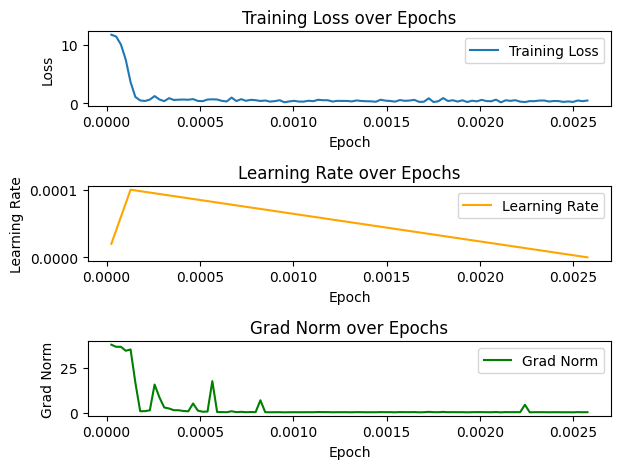

In [111]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in turkishReviews_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## GPT-2 900M

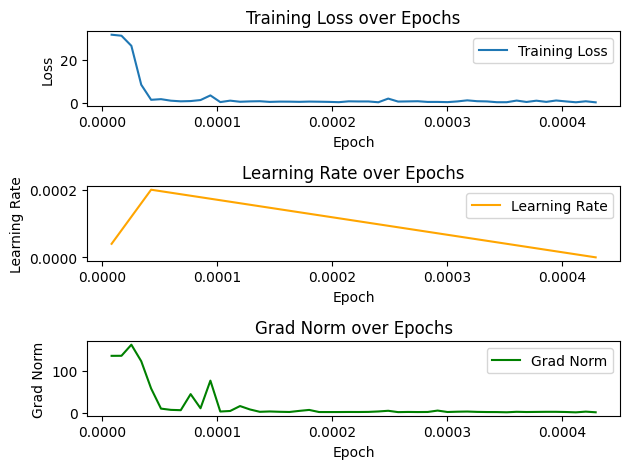

In [112]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in gpt2_900M_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## GPT-2

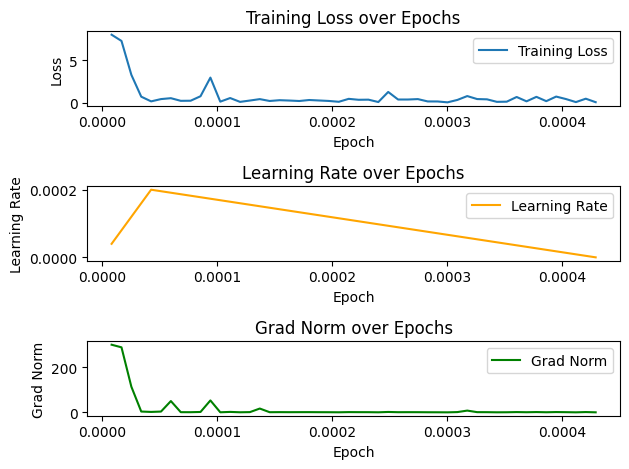

In [113]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in gpt2_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## GPT-2 Large

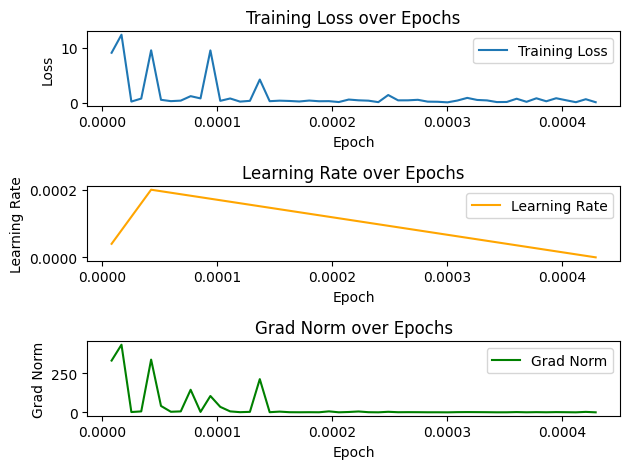

In [114]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in gpt2_large_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## GPT-2 Medium

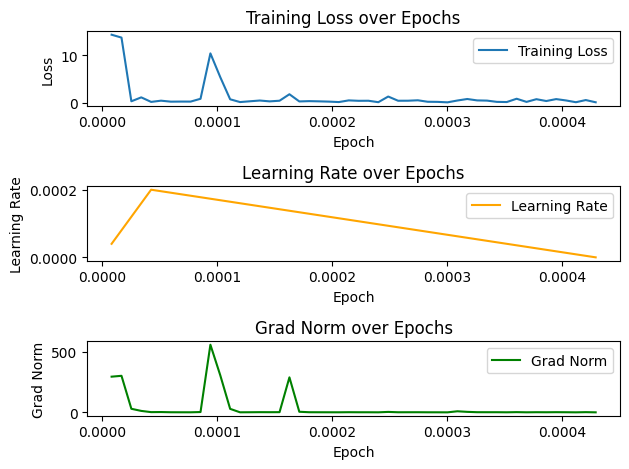

In [115]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in gpt2_medium_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Kanarya

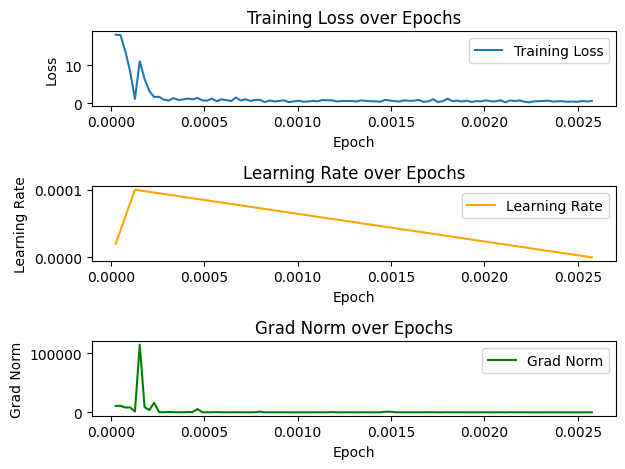

In [116]:
import matplotlib.pyplot as plt

# Extract epochs, training losses, learning rates, and grad norms
epochs = []
training_losses = []
learning_rates = []
grad_norms = []

for log in kanarya_log:
    if 'epoch' in log and 'loss' in log:
        epochs.append(log['epoch'])
        training_losses.append(log['loss'])
    if 'epoch' in log and 'learning_rate' in log:
        learning_rates.append(log['learning_rate'])
    if 'grad_norm' in log:
        grad_norms.append(log['grad_norm'])

# Create subplots
fig, axs = plt.subplots(3)

# Plot training loss
axs[0].plot(epochs, training_losses, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Plot learning rate
axs[1].plot(epochs, learning_rates, label='Learning Rate', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')
axs[1].set_title('Learning Rate over Epochs')
axs[1].legend()

# Plot grad norm
axs[2].plot(epochs, grad_norms, label='Grad Norm', color='green')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Grad Norm')
axs[2].set_title('Grad Norm over Epochs')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
